![Title](Images/cisco.png)

# Lab - Image Processing Change Detection

### Objectives
<p>
<li>**Part 1: Learn About Computer Imaging**</li>
<li>**Part 2: Capture Images**</li>
<li>**Part 3: Change Detection**</li>
<li>**Part 4: Explanation and Application**</li>

### Scenario/Background
Detecting moving objects in a scene is one of the most important tasks in computer vision. It is useful for video surveillance, for instance, but it is usually the basis for other, more complex tasks.

Usually the way this task is performed is by building a model of an empty scene and comparing each newly captured frame to it. When the model of the empty scene is different from the current scene, it means that something in the image has changed. 

In this lab, we are going to use a video camera attached to the Raspberry Pi to capture videos and images. We will build a very simple background model that will allow us to detect changes in the scene that the camera is capturing. We are capturing the images and converting them into matrices of numbers that can be operated on mathematically. This is different from capturing images and saving them as files.
### Required Resources
<p>
* 1 PC with Internet access
* Raspberry Pi version 2 or higher
* Python libraries: numpy, cv2, picamera, time, pyplot, numpy
* Picamera V2 module

The Raspberry Pi camera module was connected and installed in a previous lab. This lab assumes that the installation and testing of the camera module have previously been completed.

## Part 1: Learn About Computer Imaging

Let's have a look at the kind of data we are going to work with: digital images and videos.

A digital image is a matrix composed of pixels. Each pixel corresponds to a position inside of the image and contains information regarding the color of the image at that location. If the image is grayscale, each pixel contains a number that identifies the `level of gray` in that position. If we are looking at a color image, then each pixel contains a vector that encodes a color according to a certain color map. For instance, if we are using the RGB color map, each color is encoded by a group of three numbers. The numbers reprent the quantity of red, blue and green that makes up the color of the pixel. 

So, if we want to compare what we see versus what the computer sees, it would be something like this:

![title](Images/lisa_n.png)

Each pixel in an image that is using the RGB color space has three RGB values that range from 0 to 255 that define the color of that pixel. An image that is 256 pixels high and 256 pixles wide has 65,536 pixels. Each pixel has 24 bits of color information associated with it in an RGB color space. (The 24 bits consist of eight bits each for the red, green, and blue color channels.) The figure shows a numeric array that represents a 16x16 pixel area of the larger image. The values in the numeric array for each pixel represent the red value in that pixel. The pixels also have green and blue values that are not shown for clarity. The combination of the red, green, and blue values can depict 16,777,216 color variations (256 to the third power).

Computer vision is a demanding computer task, and it requires a lot of work in terms of pre-processing to transform a raw digital image into a form that is understandable by a computer as data.

The resolution of an image (or a video) is the number of pixels contained in the image (or each frame), and it is usually expressed by the number of rows and the number of colums (e.g, 256x256 means that an image has 256 rows and 256 columns of pixels).

A digital video is a sequence of frames, and each frame is a digital image. Digital videos can have different frame rates that are expressed as the number of images per second. Video standards vary, but a full-motion digital video is usually around 30 frames per second. Other frame rates can be used depending on the purpose of the video and the amount of bandwidth and storage that are available.

## Part 2: Capture Images

In this part of the lab, we will use Python to automatically capture a series of images.

##### Step 1: Setup the environment.
Import all the libraries we need to perform the task.

In [1]:
#code cell 1
# import the necessary packages
import cv2
from IPython.display import clear_output
from picamera.array import PiRGBArray
from picamera import PiCamera
import time
from matplotlib import pyplot as plt
import numpy as np
%matplotlib inline

OpenCV (Open Source Computer Vision) is a library of programming functions mainly aimed at real-time computer vision. The cv2 package that we imported in the previous cell is the OpenCV package for Python. 

##### Step 2: Test the camera.
First, we will test the camera to see if is working properly. 

###### a) Capture a single image.
Position the camera so that it will capture the image that you want and run the following code. The output of the code will be the captured image.

ok


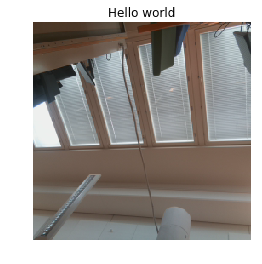

In [2]:
#code cell 2
# sanity check, to be sure that no other processes are using the camera
try:
    camera.close()
    del camera
except:
    print('ok')
    
#initialize the camera by creating a camera object from the PiCamera() method.
camera = PiCamera()
# set the resolution of the picture to be taken
camera.resolution = (256, 256)
# set the frame rate
camera.framerate = 1
# create an object for the captured image
rawCapture = PiRGBArray(camera)
 
# allow the camera to warmup
time.sleep(0.1)

# Capture a frame from the camera by using the capture() method of the camera object.
# Create an array from the capture and display the image array. 
# The plt.show() method is used as if the image were a graph.
try:
    camera.capture(rawCapture, format="rgb")
    image = rawCapture.array
    # Turn off the axis
    plt.axis('off')
    # Title of the picture
    plt.title("Hello world")
    # show the frame
    plt.imshow(image)
    plt.show()
    # release the camera
    camera.close()
except:
    # Release the Video Device
    camera.close()
    print('Something went wrong')

###### b) Capture a sequence of images.
In order to capture image sequences, we will create an infinite loop and capture images periodically as the loop repeats. Add or move items whithin the frame. You will see the video update after a short delay. This is like a very low frame rate video. 

In order to go on to code cell 4, stop code cell 3 by clicking the button with the square icon to the left of the code cell.

Released Video Resource


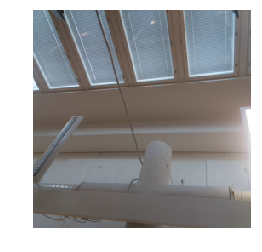

In [12]:
#code cell 3
# release the camera resource in case another process is using it
try:
    camera.close()
except:
    print('ok')

# initialize the camera and create a reference to the raw camera capture
camera = PiCamera()
camera.resolution = (256, 256)
camera.framerate = 1
rawCapture = PiRGBArray(camera)
 
# allow the camera to warmup
time.sleep(0.1)

try:
    # capture frames from the camera
    while True:
        # grab an image from the camera
        camera.capture(rawCapture, format="rgb")
        image = rawCapture.array
        # Turn off the axis
        plt.axis('off')
        # Title of the window
        plt.title("Video Frame")
        plt.axis('off')

        # show the frame
        plt.imshow(image)
        plt.show()
        # Display the frame until new frame is available
        clear_output(wait=True)
        # clear the stream in preparation for the next frame
        rawCapture.truncate(0)

except:
    # release the video device
    camera.close()
    # message to be displayed after releasing the device
    print("Released Video Resource")
    # show the last frame
    plt.imshow(image)
    plt.axis('off')
    plt.show()

## Part 3: Change Detection

Now we are ready to build a model of the background of the scene. The assumptions we are making are:

- The camera is still.
- The background is static.
- The background is very simple and monochromatic, if possible.
- The light conditions are consistent.

If these assumptions are true, our simple model will be more than enough to perform change detection.

In theory we could take one frame and use that as the model. In order to make the model slightly more resistant to noise, we are going to collect a few frames and use their average as the model.

##### Step 3: Modelling the background
Write the auxiliary functions to build the background model.

###### a) Define a countdown function
This function gives warning to the operator to clear the scene so a plain background is captured.

In [4]:
#code cell 4
def countdown(count):
    print('seconds to background acquisition:')
    while (count >= 0):
        print(count)
        count -= 1
        time.sleep(1)

###### b) Create the background reference image.
Define a function that collects a number of frames of the empty scene and returns their average.

In [5]:
# code cell 5
# this is the function we are going to call to collect and average the frames
# camera is the instance of the camera we are using
# secs2countdown is the amount of time we give to the operator to clear the scene
# n_frames is the number of frames we are going to average to build the background model

def get_background(camera, rawCapture, secs2countdown=5, n_frames=10):
    countdown(secs2countdown)
    k=0
    # capture n_frames. These frames will be averaged to create the background model.
    while(k<=n_frames):
        # capture a frame of the empty scene
        camera.capture(rawCapture, format="bgr")
        # for computational reasons, we are going to work in grayscale (only one channel). 
        # This is an opencv function to convert color images to grayscale
        frame = cv2.cvtColor(rawCapture.array, cv2.COLOR_BGR2GRAY)
        if(k==0):
            background_frame=np.array(frame).astype(float)
        else:
            background_frame+=np.array(frame).astype(float)
        # clear the stream in preparation for the next frame
        rawCapture.truncate(0)
        k+=1
    print('Background acquired, thanks!')
    # return the average of the acquired frames
    return background_frame/float(k)

###### c) Create and store the background model.
Initialize the camera and run the function that will capture and average the background images. This will take some time.

In [8]:
#code cell 6
# ensure that the camera resource is available
try:
    camera.close()
    del camera
except:
    print('ok')

# initialize the camera settings   
camera = PiCamera()
camera.resolution = (256, 256)
camera.framerate = 1
rawCapture = PiRGBArray(camera)

# store the background image by creating an object to hold the output of the get_background() function
bg = get_background(camera, rawCapture)

seconds to background acquisition:
5
4
3
2
1
0
Background acquired, thanks!


###### d) View the background image.
Display the image that was captured. It is displayed as a gray scale image, which is what will be used for the change detection algorithm.

In [ ]:
#code cell 7
plt.imshow(bg, cmap='gray')
plt.title('Background')
plt.axis('off')

#### Step 4: Detect moving objects.

In order to detect a change in the captured image, the stored background image will be subtracted from the current frame. Because of noise, the difference between the stored background and the current background will not always be exactly zero if no change has occurred. In order to avoid falsely detecting change, we will have to set a threshold that will let us decide whether the difference between the two images is small enough to be considered zero or if we think that something is actually moving in the scene.

Execute the following code. The code will loop indefinately until it is stopped.

In [11]:
# code cell 8
try:
    camera.close()
    del camera
except:
    print('ok')
    
camera = PiCamera()
camera.resolution = (256, 256)
camera.framerate = 1
rawCapture = PiRGBArray(camera)
# manipulate this value to see how it affects the capture
threshold = 100
try:
    # capture frames from the camera
    while True:
        # capture an image from the camera
        camera.capture(rawCapture, format="bgr")
        image = cv2.cvtColor(rawCapture.array, cv2.COLOR_BGR2GRAY)
        # Create and size the figure object
        fig = plt.figure(figsize=(16, 20))
        
        #create and format the background image
        plt.subplot(131)
        plt.title('Background Reference')
        plt.imshow(bg, cmap='gray')
        plt.axis('off')
        
        #create and format the background image
        plt.subplot(132)
        plt.title('Current Image')
        plt.imshow(image, cmap='gray')
        plt.axis('off')
        
        #create the change detection image
        plt.subplot(133)
        plt.title('Change Detection')
        #this line subtracts the background image "bg" from the current image
        plt.imshow((np.absolute(bg-image)>threshold), cmap='gray')
        plt.axis('off')
        plt.show()
                
        # Display the frame until the new frame is available
        clear_output(wait=True)
        # clear the stream in preparation for the next frame
        rawCapture.truncate(0)

except:
    # Release the Video Device
    camera.close()
    # Message to be displayed after releasing the device
    print("Released Video Resource")
    # show the last frame
    fig = plt.figure(figsize=(16, 20))
        
    #the background reference image
    plt.subplot(131)
    plt.title('Background Reference')
    plt.imshow(bg, cmap='gray')
    plt.axis('off')
        
    #the current image
    plt.subplot(132)
    plt.title('Current Image')
    plt.imshow(image, cmap='gray')
    plt.axis('off')
        
    #the change detected image
    plt.subplot(133)
    plt.title('Change Detection')
    plt.imshow((np.absolute(bg-image)>threshold), cmap='gray')
    plt.axis('off')
    plt.show()

Released Video Resource


KeyboardInterrupt: 

*Type your answers here*

#### Application
Digital video cameras have become inexpensive, plentiful, and practical to use. Video cameras that are connected to networks can be seen in many cities and businesses. Some of these cameras are connected to the Internet. The streams of video data that they produce are processed and analyzed at the network edge or in the Cloud. What is this video data used for?

An obvious application is for security and surveillance. Basic change detection algorithms like the one demonstrated in this lab could be used to detect the actions of people or the movement of things. Change detection can be used to detect when parking places become vacant or when store shelves are empty. In traffic management, a change detection process can be used to compare the current conditions on a highway to the expected conditions for that time and day. A differrence may indicate a traffic jam in or near the area that the camera is monitoring. This could be used to alert public safety personnel of the need to investigate road conditions.

Can you think of any other applications for analysis of video data and change detection?

*Type your answers here*

<font size='0.5'>&copy; 2017 Cisco and/or its affiliates. All rights reserved. This document is Cisco Public.<font>